In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

import tensorflow as tf
import tensorflow_probability as tfp

from gemlib.util import compute_state
from gemlib.distributions import DiscreteTimeStateTransitionModel
from gemlib.distributions import UniformInteger
from gemlib.distributions import UniformKCategorical

from chain_binomial_rippler import chain_binomial_rippler

tfd = tfp.distributions

## Basic SI model

In [2]:
stoichiometry = np.array([[-1, 1]])
init_state = np.array([[99.0, 1.0]])

def hazard_fn(t, state):
    si = 0.1 * state[..., 1] / tf.reduce_sum(state, axis=-1)
    return [si]

model = DiscreteTimeStateTransitionModel(transition_rates=hazard_fn, 
                                         initial_state=init_state, 
                                         initial_step=0,
                                         time_delta=1.0,
                                         num_steps=100,
                                         stoichiometry=stoichiometry)

2022-01-12 17:34:33.819180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 17:34:33.823694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 17:34:33.824002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 17:34:33.824750: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2022-01-12 17:34:34.486535: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


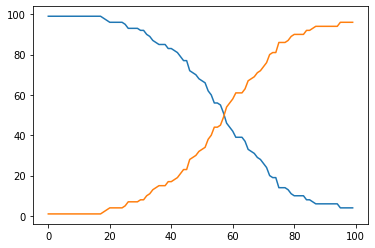

In [3]:
events = model.sample()
state = compute_state(initial_state=init_state, events=events, stoichiometry=stoichiometry)

plt.plot(state[0,...,0], label="S")
plt.plot(state[0,...,1], label="I")

# Run a simulation

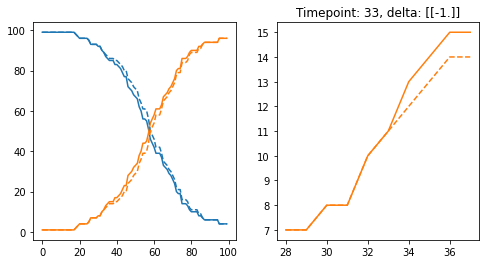

In [11]:
new_events, info = chain_binomial_rippler(model, events)
new_state = compute_state(initial_state=init_state, events=new_events, stoichiometry=model.stoichiometry)

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].plot(state[0,...,0], color='C0', label='S original')
ax[0].plot(state[0,...,1], color='C1', label='I original')
ax[0].plot(new_state[0,...,0], '--', color='C0', label='S new')
ax[0].plot(new_state[0,...,1], '--', color='C1', label='I new')
lower = np.clip(info['timepoint'] - 5, 0, None)
upper = np.clip(lower + 10, None, state.shape[-2])
ax[1].plot(range(lower, upper), state[0, lower:upper, 1], color='C1')
ax[1].plot(range(lower, upper), new_state[0, lower:upper, 1], '--', color='C1')
_ = plt.title(f"Timepoint: {info['timepoint']}, delta: {info['delta']}")


# Proposal video

In the following video, we iteratively apply `update_trajectory` to the SI events, and look for random walk behaviour of the overall stochastic process trajectory. 

In [13]:
def make_chart_func(initial_events, model):
    
    fig, ax = plt.subplots()
    lineS, = ax.plot([], color='C0', label='S')
    lineI, = ax.plot([], color='C1', label='I')
    ax.set_xlim(0, initial_events.shape[-2])
    ax.set_ylim(0, 110)
    
    events = initial_events
    
    def chartfunc(t):
        nonlocal events
        events, info = chain_binomial_rippler(model, events)
        ax.set_title(f"Frame: {t}, t_idx: {info['timepoint']}, delta: {info['delta']}")
        new_state = compute_state(initial_state=model.initial_state, 
                                  events=events, 
                                  stoichiometry=model.stoichiometry)
        lineS.set_data((np.arange(new_state.shape[-2]), new_state[0,...,0]))
        lineI.set_data((np.arange(new_state.shape[-2]), new_state[0,...,1]))
    return fig, chartfunc

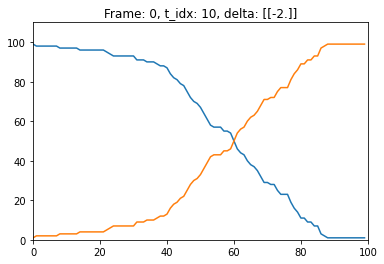

In [14]:
import matplotlib.animation as ani

fig, chartfunc = make_chart_func(events, model)
anim = ani.FuncAnimation(fig, chartfunc, frames=500, interval=40)
HTML(anim.to_html5_video())

# Embed proposal in MCMC algorithm